# Fully Connected Net

For our least intelligent baseline, just *flatten* all of the layers and train a MLP classifier.

Since the DataLoader has multiple inputs, I think we need to use the module API. 


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import FCNet, count_parameters
from train import check_accuracy, train
from plottingFcts import trainingMetrics, sigBkgEff, plotROC, plotConfusion

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=256)

In class, they said the network usually saturated with about 3 different hidden layers, so a default architecture I'm trying has hidden dimensions {150, 100, 50}, although these are hyperparams that I could (possibly) tune. I'm also using batchnorm and dropout!

In [5]:
myModel = FCNet(h1_dim=300,h2_dim=200,h3_dim=100)

In [6]:
count_parameters(myModel)

233303

#### Sanity check
Before training, the validation accuracy should be about 33%

In [7]:
check_accuracy(loader_val, myModel)

cuda
Got 9475 / 30000 correct (31.58)


### Next step: Train the net!

For simplicity, just use the adam optimizer!


In [8]:
optimizer = optim.Adam(myModel.parameters(), lr = 1e-5)

In [9]:
np.log(3)

1.0986122886681098

In [15]:
history, myModel = train(loader_train, loader_val, myModel, optimizer, epochs=25, returnBest=True)


Epoch 1/25:
Iteration 0, loss = 0.4252
cuda
Got 22904 / 30000 correct (76.35)

Iteration 100, loss = 0.4287
cuda
Got 22914 / 30000 correct (76.38)

Iteration 200, loss = 0.4492
cuda
Got 22877 / 30000 correct (76.26)

Iteration 300, loss = 0.4122
cuda
Got 22912 / 30000 correct (76.37)

Iteration 400, loss = 0.3950
cuda
Got 22883 / 30000 correct (76.28)

Iteration 500, loss = 0.4470
cuda
Got 22893 / 30000 correct (76.31)

Iteration 600, loss = 0.4275
cuda
Got 22888 / 30000 correct (76.29)

Iteration 700, loss = 0.3921
cuda
Got 22864 / 30000 correct (76.21)

cuda
Got 137618 / 180000 correct (76.45)
cuda
Got 22937 / 30000 correct (76.46)

Epoch 2/25:
Iteration 0, loss = 0.4773
cuda
Got 22972 / 30000 correct (76.57)

Iteration 100, loss = 0.4522
cuda
Got 22952 / 30000 correct (76.51)

Iteration 200, loss = 0.5377
cuda
Got 22901 / 30000 correct (76.34)

Iteration 300, loss = 0.4997
cuda
Got 22904 / 30000 correct (76.35)

Iteration 400, loss = 0.4313
cuda
Got 22906 / 30000 correct (76.35)

I

Iteration 700, loss = 0.3775
cuda
Got 23040 / 30000 correct (76.80)

cuda
Got 138098 / 180000 correct (76.72)
cuda
Got 23017 / 30000 correct (76.72)

Epoch 14/25:
Iteration 0, loss = 0.4215
cuda
Got 23013 / 30000 correct (76.71)

Iteration 100, loss = 0.4472
cuda
Got 22996 / 30000 correct (76.65)

Iteration 200, loss = 0.4684
cuda
Got 23040 / 30000 correct (76.80)

Iteration 300, loss = 0.4278
cuda
Got 23030 / 30000 correct (76.77)

Iteration 400, loss = 0.4298
cuda
Got 22953 / 30000 correct (76.51)

Iteration 500, loss = 0.3995
cuda
Got 23008 / 30000 correct (76.69)

Iteration 600, loss = 0.4145
cuda
Got 23021 / 30000 correct (76.74)

Iteration 700, loss = 0.4032
cuda
Got 22990 / 30000 correct (76.63)

cuda
Got 137934 / 180000 correct (76.63)
cuda
Got 23007 / 30000 correct (76.69)

Epoch 15/25:
Iteration 0, loss = 0.4550
cuda
Got 22987 / 30000 correct (76.62)

Iteration 100, loss = 0.3945
cuda
Got 23023 / 30000 correct (76.74)

Iteration 200, loss = 0.4257
cuda
Got 23041 / 30000 corre

In [16]:
check_accuracy(loader_val, myModel)

cuda
Got 23036 / 30000 correct (76.79)


## Plot the loss and accuracy curves

- I'm only calculating the accuracies after each epoch, because it was prohibitively slow when I was printing after each iteration.

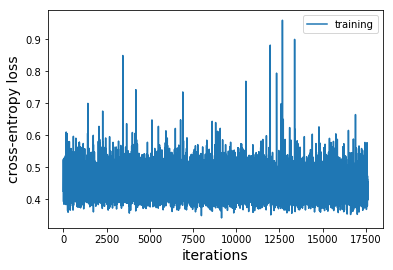

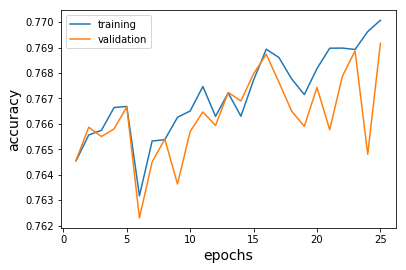

In [17]:
trainingMetrics(history)

## Discriminant plots / ROC Curves

Ok, so for the ROC curves, use the discriminant

$$D_\gamma = \frac{p_\gamma}{p_\pi + p_e}$$

Where $p_i$ corresponds to the output of the softmax node, and this discriminant separates a $\gamma$ signal from a $\pi$ and $e$ background, and we can define similar discriminants for $\pi^+$ or $e^+$ signal.

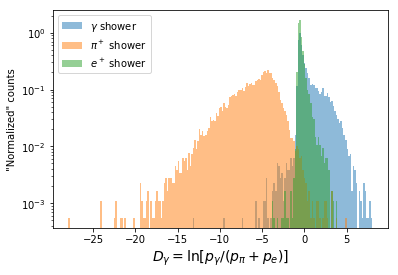

../plottingFcts.py:229: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


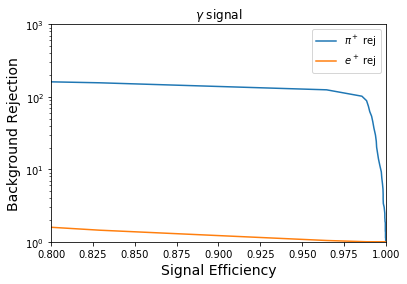

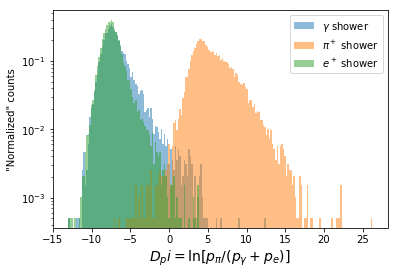

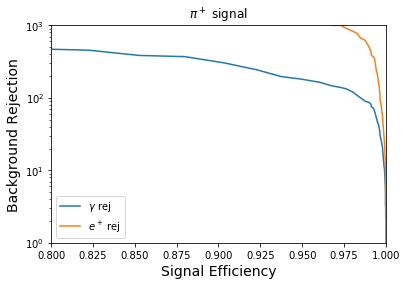

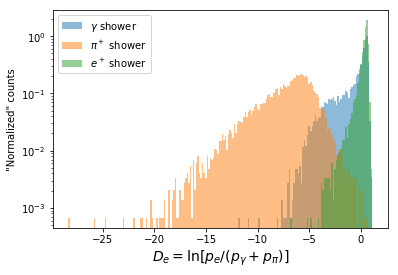

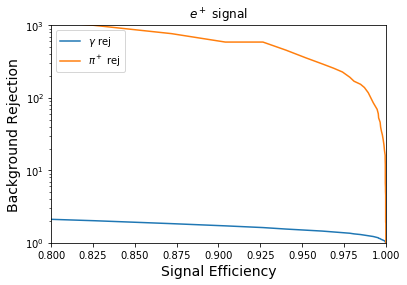

In [18]:
particles = ['gamma','pi','e']

for node in range(3):
    g_eff, pi_eff, e_eff = sigBkgEff(myModel, loader_val, node)
    mTag = '{}-sig_{}'.format(particles[node], myModel.modelName)
    
    # Plot the ROC curve using node as the signal and the other two as the bkg
    if node == 0:
        plotROC([g_eff, g_eff], [pi_eff, e_eff], ['$\pi^+$ rej', '$e^+$ rej'], title='$\gamma$ signal', tag=mTag)
    if node == 1:
        plotROC([pi_eff, pi_eff], [g_eff, e_eff], ['$\gamma$ rej', '$e^+$ rej'], title='$\pi^+$ signal', tag=mTag)
    elif node == 2:
        plotROC([e_eff, e_eff], [g_eff, pi_eff], ['$\gamma$ rej', '$\pi^+$ rej'], title='$e^+$ signal', tag=mTag)
        

**Notes:**

To see which classes we tend to misclassify the most, look at the confusion matrix between the classes.


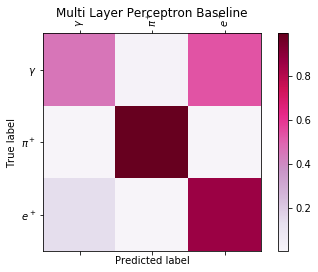

In [19]:
plotConfusion(myModel, loader_val, title="Multi Layer Perceptron Baseline")

# Other Experiments

- I tried a fc model with more hidden neurons: 300-200-100 for 233k trainable parameters, training for 75 epochs with a learning rate $\alpha = 10^{-5}$, but the best validation accuracy I got was ()%, suggesting that my simpler 150-100-50 model was actually sufficiently complex for this architeture.

